In [44]:
import pandas as pd
import pyodbc as sql
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from scipy.stats import multivariate_normal as mvn
import nltk
import os
import random
import string
# email module has some useful functions
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys, email,re

In [24]:
def getDBConnection():
    db = sql.connect("Driver={SQL Server Native Client 11.0};"
                                  "Server=IN2171460W1\MS_SQL17;"
                                  "Database=PST_Analytics;"
                                  "Trusted_Connection=yes;")
    cursor=db.cursor()
    return(db,cursor)

In [37]:
def Data():
    db, cursor = getDBConnection()
    query = "SELECT * FROM Email_Info"
    df = pd.read_sql(query, db)
    db.commit()
    return df

In [64]:
df=Data()
df.head()

,PST_ID,Folder,Email_To,Email_From,Email_CC,Email_BCC,Email_body,Email_CreationTime,Email_Subject,Email_ID,CleanSubject,Email_Header,Clean_Email_From,CleanBody
0,5c909a60-c9ab-4d29-9bdf-ef12cbb80ab6,Purges,Dilpreeta Vasudeva/COMMS/MUM CORP/MH,mCube Awards,,,,08-10-2018 08:33:20,MarketingMojo #5 (OOH): Dedicated Categories t...,30,MarketingMojo5OOHDedicatedCategoriestoacknowle...,Received: from HK2PR01MB1380.apcprd01.prod.exc...,,
1,5c909a60-c9ab-4d29-9bdf-ef12cbb80ab6,Purges,DL-Marketing Updates Customer Ops,Arpit Gupta/MKTG/MUM CORP/MH,DL-Commercial Mumbai;DL-Commercial Bangalore;D...,,,08-10-2018 08:33:20,India Tour of Ireland & England 2018,31,IndiaTourofIrelandEngland2018,Received: from HK2PR01MB1156.apcprd01.prod.exc...,,
2,5c909a60-c9ab-4d29-9bdf-ef12cbb80ab6,Purges,Siddharth Parida/COMMS/MUM CORP/MH,Rahul Dutta/COMMS/DEL/DL,Dilpreeta Vasudeva/COMMS/MUM CORP/MH;Nitya Kab...,,,08-10-2018 08:33:20,RE: Tata Sky - Ezmall,32,RETataSkyEzmall,Received: from sg2pr01cu004.internal.outlook.c...,,
3,5c909a60-c9ab-4d29-9bdf-ef12cbb80ab6,Purges,DL-Marketing Updates Customer Ops,Rohit Mishra/MKTG/MUM CORP/MH,Pallavi Puri/MKTG/MUM CORP/MH;Sayantani Gupta/...,,,08-10-2018 08:33:20,Launching Demo pack for Tata Sky dealers | 22n...,33,LaunchingDemopackforTataSkydealers22ndJune,Received: from HK2PR01MB1217.apcprd01.prod.exc...,,
4,5c909a60-c9ab-4d29-9bdf-ef12cbb80ab6,Purges,DL-Communications,Sangeeta Lobo/MKTG/MUM CORP/MH,,,,08-10-2018 08:33:20,FW: Laddoos got for us by Deepak Rane. Thanks...,34,FWLaddoosgotforusbyDeepakRaneThanksDeepak,Received: from KL1PR01MB0709.apcprd01.prod.exc...,,


In [87]:
df['Date'] = pd.to_datetime(df['Email_CreationTime'], infer_datetime_format=True)
df.head()
df.dtypes

PST_ID                        object
Folder                        object
Email_To                      object
Email_From                    object
Email_CC                      object
Email_BCC                     object
Email_body                    object
Email_CreationTime            object
Email_Subject                 object
Email_ID                       int64
CleanSubject                  object
Email_Header                  object
Clean_Email_From              object
CleanBody                     object
Date                  datetime64[ns]
dtype: object

In [88]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.dayofweek


In [75]:
df_Purges  = df[df['Folder']=='Purges']
df_Inbox  = df[df['Folder']=='Inbox']

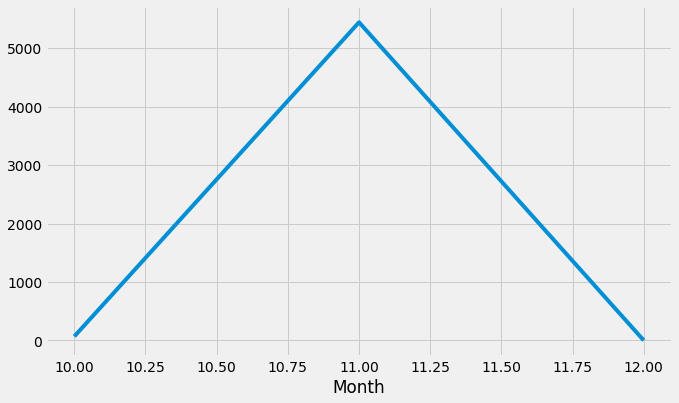

In [58]:
indices = (df['Month'] >8) & (df['Month'] <= 12)
plt.figure(figsize = (10,6))
figure1 = df.loc[indices].groupby('Month')['Email_body'].count().plot()

In [60]:
df.Year.agg({'max': max, 'min': min})
# really should not be dates up to 2044
df[df['Year']==2019]

,PST_ID,Folder,Email_To,Email_From,Email_CC,Email_BCC,Email_body,Email_CreationTime,Email_Subject,Email_ID,CleanSubject,Email_Header,Clean_Email_From,CleanBody,Date,Month,Year,Day


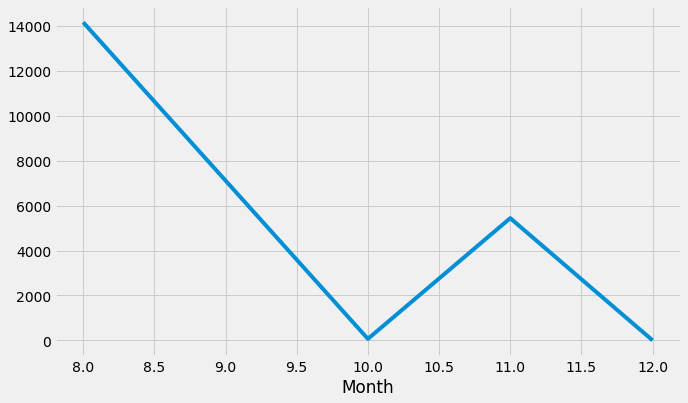

In [61]:
plt.figure(figsize = (10,6))
figure2 = df.groupby('Month')['Email_body'].count().plot()

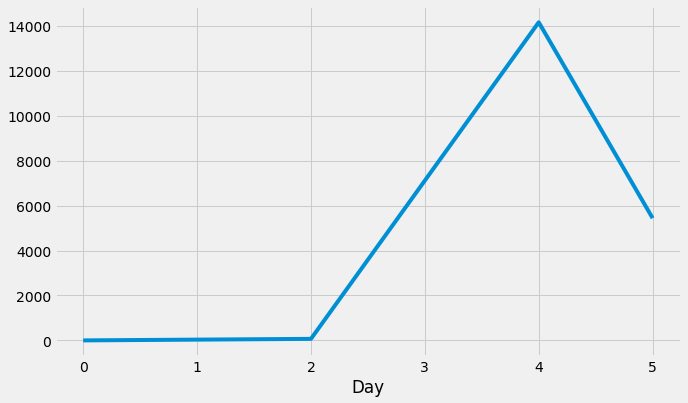

In [62]:
plt.figure(figsize = (10,6))
figure3 = df.groupby('Day')['Email_body'].count().plot()

In [63]:
#Unique to and From
print('Total number of emails: %d' %len(df))
print('------------')
print('Number of unique received: %d '%df['Email_To'].nunique())
print('------------')
print('Number of unique Sent: %d '%df['Email_From'].nunique())

Total number of emails: 19670
------------
Number of unique received: 3327 
------------
Number of unique Sent: 1028 


In [77]:
top_10_frequent = df.groupby('Email_From')['PST_ID'].count().sort_values(ascending = False)[:30]
top_10_frequent

Email_From
Dilpreeta Vasudeva/COMMS/MUM CORP/MH    2100
Tatasky.Reports@tatasky.com             1404
Enakshi Chatterjee/COMMS/MUM CORP/MH    1072
My HR                                   1070
admin@tatasky.com                       1036
infaprod@tatasky.com                     905
CONCEPTBIU                               605
Admin                                    552
Abhishek Seth/COMMS/MUM CORP/MH          455
Karan Kapoor/COMMS/MUM CORP/MH           427
i-Digest@impactmeasurement.co.in         323
Basis                                    228
ODS@tatasky.com                          181
CCTReport_Automation@tatasky.com         178
Sanya Deshmukh                           164
                                         152
Ashwini Kumar Das                        149
quarantine@messaging.microsoft.com       149
Sabita Chawla/IT/BLR/KAR                 145
Notification                             143
Daily Post                               141
Vipin Menon                              139

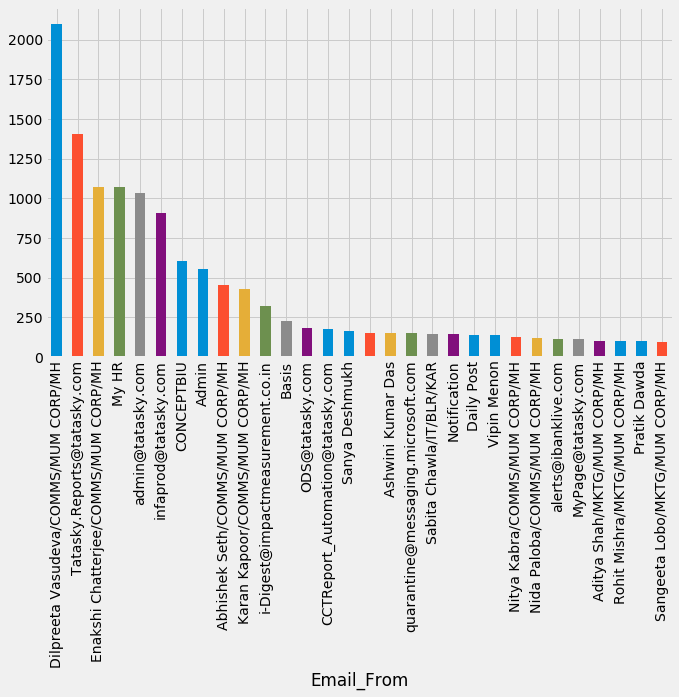

In [78]:
plt.figure(figsize = (10,6))
top_10_frequent.plot(kind = 'bar')

In [81]:
folder_data  = df.groupby('Folder')['PST_ID'].count().sort_values(ascending = False)[:30]
folder_data

Folder
Purges                  14268
Reports                  3346
PO                       1075
News                      682
Notifications             144
Drafts                     63
Archive                    38
Conversation History       33
Inbox                      15
Conflicts                   3
Email Administrator         2
Deleted Items               1
Name: PST_ID, dtype: int64

In [132]:
df.groupby(['Email_From','Month'])['PST_ID'].count()

KeyError: 'Email_From'

In [131]:
def split_data(data):
    if data is not None:
        temp = data.split(';')
        if len(temp) == 1:
            return 'Direct'
        else:
            return 'Multiple'
    else:
        return 'Empty'
df['Direct_or_multi'] = df['Email_To'].apply(split_data)

KeyError: 'Email_To'

In [106]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # strip html 
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['Subject_new'] = df['Email_Subject'].apply(clean_column)
df['body_new'] = df['Email_body'].apply(clean_column)

In [111]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

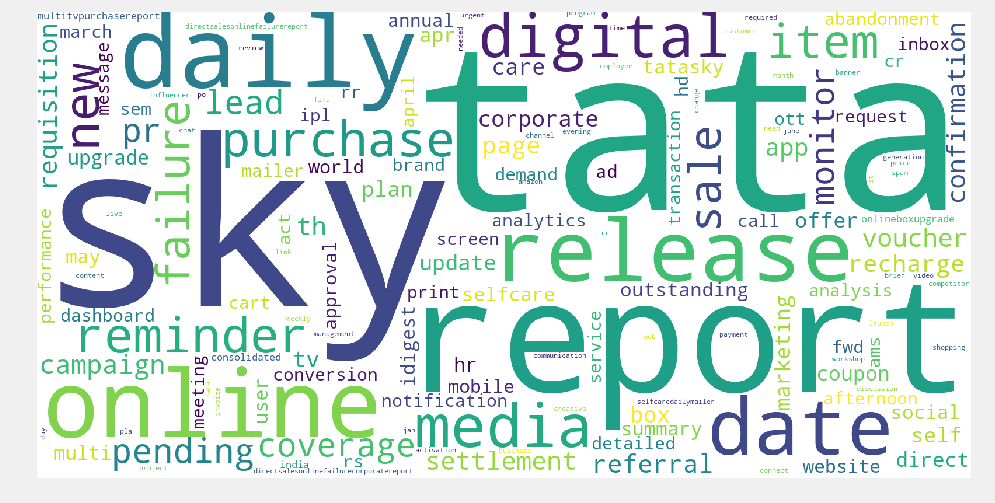

In [114]:
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['Subject_new'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(16,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

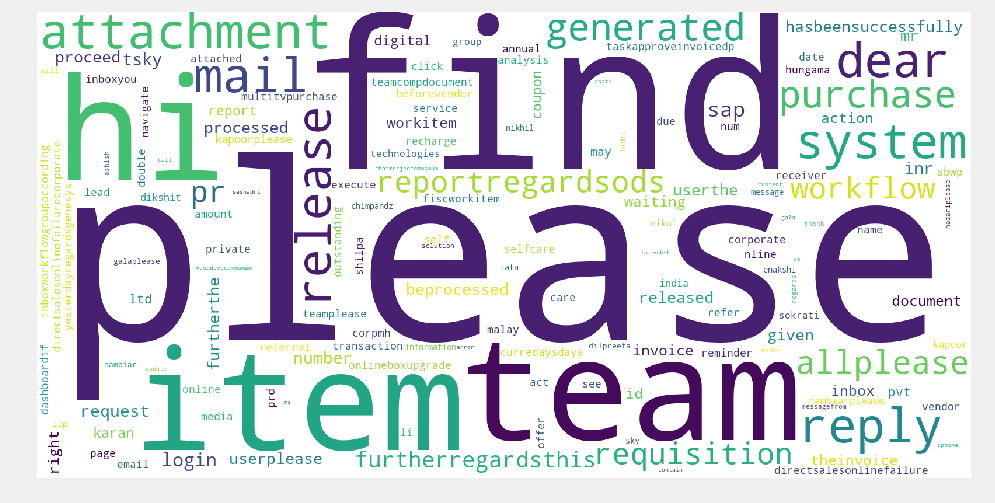

In [115]:
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['body_new'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(16,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [116]:
stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [117]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['body_new']
# data.head()

tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords,#tokenizer = tokenize_and_stem,
                             max_features = 5000)
%time tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

Wall time: 145 ms


,abhimanyug,abhiraj,abhirajabhirajkrishnacomcc,abhirajabhirajkrishnacomthis,abhirajon,abhishek,abhishekcant,abhishekdilpreeta,abhishekoriginal,abhisheksethtataskycom,...,yet,youarijit,youbestpriyanka,youbestshiladitya,youive,young,younger,younote,younotice,zirca
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    def convergence_calculation(self):
        """
        Calculates 
        
        """
        pass
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self    

array([-2.30970265,  5.8496944 ])

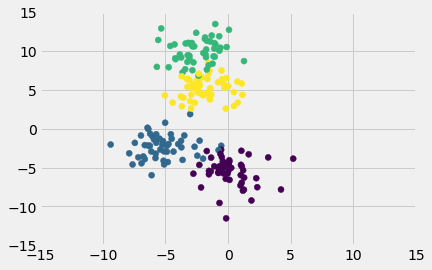

In [120]:
from sklearn.datasets import make_blobs
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)

X = data[0]
X[2]

In [121]:
temp_k  = Kmeans(4, 1, 600)
temp_fitted  = temp_k.fit_kmeans(X)
new_data = np.array([[1.066, -8.66],
                    [1.87876, -6.516],
                    [-1.59728965,  8.45369045],
                    [1.87876, -6.516]])
temp_fitted.predict(new_data)

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


array([2, 2, 1, 2], dtype=int64)

Wall time: 58 ms


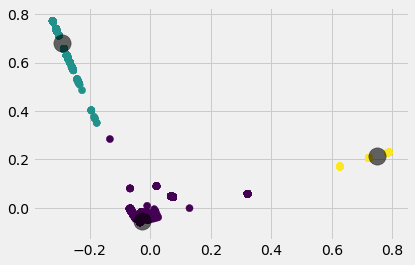

In [123]:
from sklearn.cluster import KMeans
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

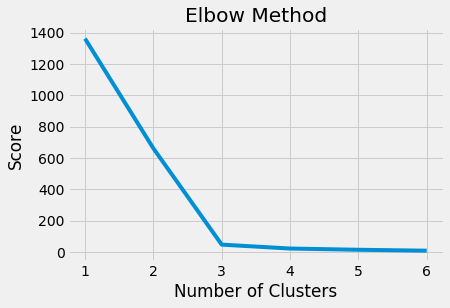

In [124]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [125]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

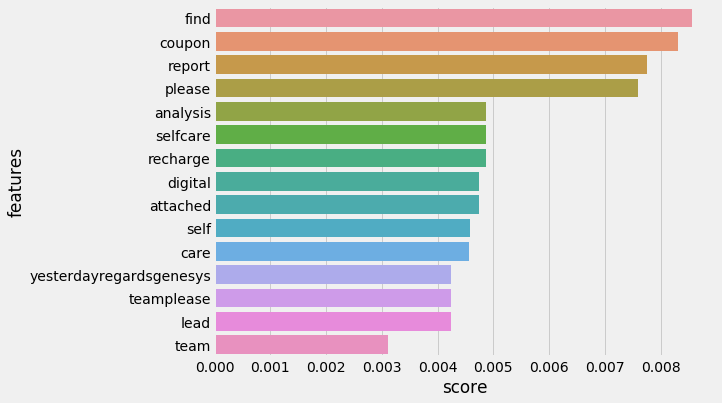

In [126]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

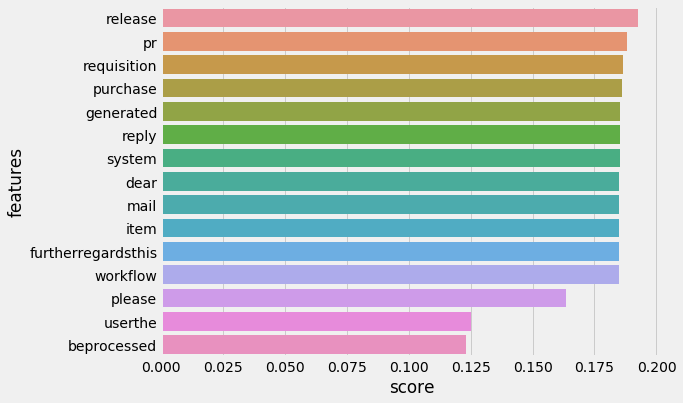

In [127]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

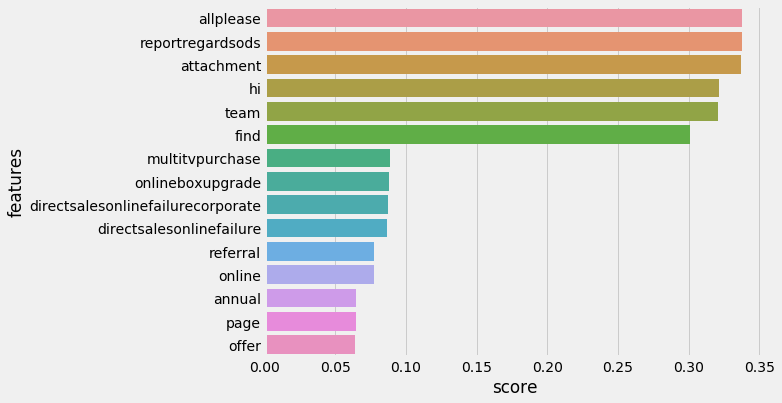

In [128]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [129]:
for i, df in enumerate(dfs):
    df.to_csv('df_'+str(i)+'.csv')

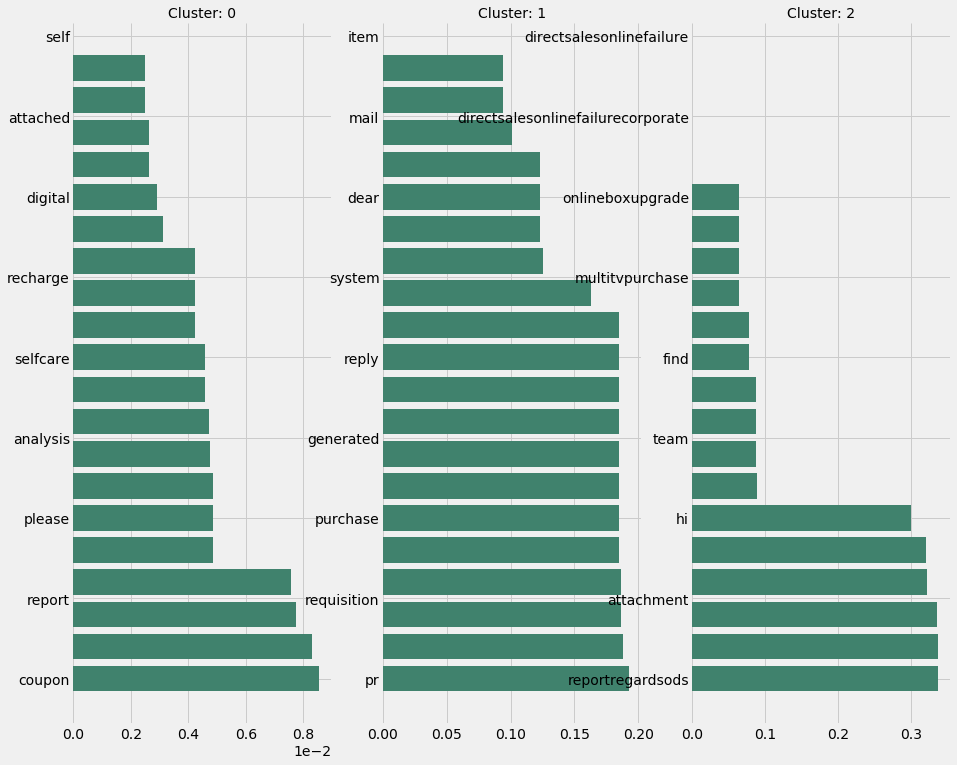

In [130]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)